### Summary
Ce projet a pour but de faire :
- dans un premier temps une classification supervisée sur la variable authorisation_status, qui definit si un médicament donné est autorisé à la vente ou non
- un modèle d'apprentissage non supervisé sur les différents groupes que la tâche précédente a permis de faire

### Analyse exploiratoire des données

In [77]:
#----------------------------Importation-des-modules-------------------------------------#
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import phik
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, silhouette_score
from sklearn.preprocessing import StandardScaler
#------------for-the-model-supervised--------------------------------------------------------------#
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from skopt.space import Real, Integer
from skopt import BayesSearchCV
from imblearn.over_sampling import SMOTE
#------------for-the-model-unsupervised--------------------------------------------------------------#
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [37]:
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2023/2023-03-14/drugs.csv"
datas = pd.read_csv(url)

In [ ]:
datas.head()

In [ ]:
datas.describe()

#### Analyse univariée
1. Typologie des variables
- Variables quantitatives

In [20]:
numerical_columns = datas.select_dtypes(include=['number']).columns
print(numerical_columns)

Index(['product_number', 'revision_number'], dtype='object')


Les variables **product_number** et **revision_number** sont considérées comme quantitatives. Cependant avec une comprehension du dataset, ces variables sont plutot qualitatives même s'elles sont représentées par des nombres.

- Variables qualitatives

In [21]:
numerical_columns = datas.select_dtypes(include=['object']).columns
print(numerical_columns)

Index(['category', 'medicine_name', 'therapeutic_area', 'common_name',
       'active_substance', 'authorisation_status', 'atc_code',
       'marketing_authorisation_date',
       'date_of_refusal_of_marketing_authorisation',
       'marketing_authorisation_holder_company_name',
       'pharmacotherapeutic_group', 'date_of_opinion', 'decision_date',
       'condition_indication', 'species', 'first_published', 'revision_date',
       'url'],
      dtype='object')


Ainsi, nous pouvons considérer l' ensemble de notre dataset comme étant des variables qualitatives.

2. Valeurs manquantes dans les colonnes
- Décompte des valeurs manquantes

In [ ]:
datas.isnull().sum()

- Visualisation des données manquantes

In [ ]:
msno.bar(datas,
         filter="top",
         color="gray"
        );

**Pour les valeurs manquantes**, on voit qu'il y'a que quelques colonnes qui en ont. 
Cependant il y'a quatre (04) colonnes qui ont plus de valeurs manquantes que les autres. Ce sont les colonnes:
- **therapeutic_area**: avec 1703 valeurs renseignées sur 1988,
- **date_of_refusal_of_marketing_authorisation**: avec 75 valeurs renseignées sur 1988
- **date_of_opinion**: avec 1209 renseignees sur les 1988
- **species**: avec seulement 279 valeurs renseignées sur les 1988

3. Sélection de colonnes

- Résumé statistique des variables

In [24]:
for col in datas.columns:
    if datas[col].dtype == 'object':  # Vérifiez si la colonne est catégorielle
        summary = datas[col].value_counts()
        print(f"Résumé de {col} :")
        print(summary)

Résumé de category :
category
human         1706
veterinary     282
Name: count, dtype: int64
Résumé de medicine_name :
medicine_name
Xeljanz                                                                                               2
Eladynos                                                                                              2
Valdoxan                                                                                              2
Yondelis                                                                                              2
Veraflox                                                                                              2
                                                                                                     ..
Pandemic influenza vaccine H5N1 AstraZeneca (previously Pandemic influenza vaccine H5N1 Medimmune)    1
Cinryze                                                                                               1
Silodyx                           

- Visualisation du nombre modalités par variable

In [ ]:
datas.nunique()

Nous constatons que beaucoup de colonnes à variables qualitatives comportent plus de 1000 modalités sur les 1988. Ainsi en combinant, les colonnes à valeurs manquantes et certaines de ces colonnes, nous avons décidé de supprimer les colonnes et ainsi réduire la dimension de notre dataset.
Les colonnes à plus de 1000 categories qui ne sont pas supprimé sont:
- medecine_name: pour le nom du medicament
- active_substance: pour la substance active dans le medicament
- common_name: le nom courant du medicament

In [40]:
new_datas = datas.drop(['marketing_authorisation_date', 'product_number', 'decision_date', 'date_of_opinion', 'first_published', 'atc_code', 'condition_indication','product_number','url', 'revision_date','species', 'date_of_refusal_of_marketing_authorisation'], axis=1)

In [41]:
new_datas.shape

(1988, 17)

#### Exploration des variables
1. Variable cible: authorisation_status

In [42]:
target = datas['authorisation_status']

Text(0.5, 1.0, 'Distribution de la variable cible')

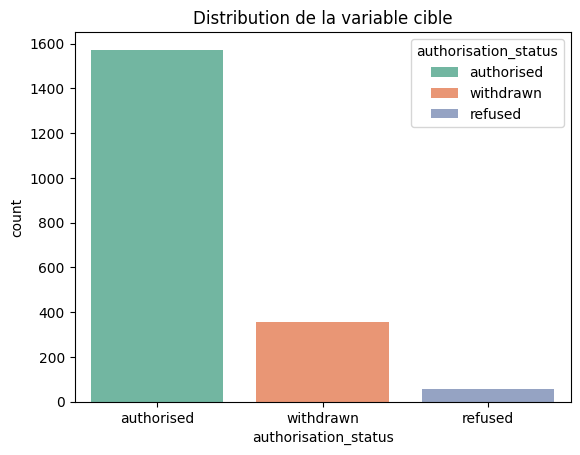

In [29]:
sns.countplot(x=target, data=datas, palette="Set2", hue=target)
plt.title("Distribution de la variable cible")

**Conclusion**: on voit que la variable cible a trois(03) categories: `autorised`, `withdrawn` et `refused`. Nous notons un certain desequilibre entre les differentes catégories

2. Distribution des autres variables

Vu le nombre de modalités sur les variables, nous allons faire des tableaux de frequence à la place des graphes de distribution

In [ ]:
colonnes_categorielles=new_datas.columns
for colonne in colonnes_categorielles:
    tableau = new_datas[colonne].value_counts().reset_index()
    tableau.columns = ['Catégorie', 'Fréquence']
    tableau['Pourcentage'] = (tableau['Fréquence'] / tableau['Fréquence'].sum()) * 100
    tableau_de_fréquence = tableau.sort_values(by='Fréquence', ascending=False)
    print(colonne+'\t')
    print("-------------------------------------")
    print(tableau_de_fréquence)
    print("-------------------------------------")

Ainsi , nous obtenu une vue sur les frequences de chaque modalité.

Nous allons maintenant voir la distribution des 2 modalités les plus représentées par classe

In [ ]:
for colonne in colonnes_categorielles:
    classe_count = new_datas[colonne].value_counts()

    top_2_classes = classe_count.head(2)

    subset_df = new_datas[new_datas[colonne].isin(top_2_classes.index)]

    tableau_croise = pd.crosstab(subset_df[colonne], subset_df[colonne])

    ax = tableau_croise.plot(kind='bar', stacked=True, figsize=(8, 6))

    ax.set_title(f'Distribution des 2 classes les plus représentées ({colonne})')
    ax.set_ylabel('Nombre d\'occurrences')

    plt.show()

**Conclusion**
Nous constatons un certain nombre de desiquilibre en les modalités de certaines variables:
- orphan_medicine: nous voyons que la portion de medicament développée pour maladie grave et rare est nettement supérieure à celle des medicaments ordinaires
- accelerated_assessment: la portion de médicament pour la santé publique est très minime par rapport à ceux qui ne le sont pas. exceptional_circumtances, conditional_approval, biosimilar suivent la même distribution

#### Analyse bi-variée

Pour materialier, l'analye bi-variée entre nos variables categorielles et nos variables cibles, nous utliserons les tableaux de contingence.

In [ ]:
variable_cible = 'authorisation_status'

# Liste des autres variables catégorielles
variables_catégorielles = [col for col in new_datas.columns if col != variable_cible]

# Créer un dictionnaire pour stocker les tableaux de contingence
tableaux_contingence = {}

# Parcourir chaque variable catégorielle et créer un tableau de contingence
for variable in variables_catégorielles:
    tableau_croise = pd.crosstab(index=new_datas[variable], columns=new_datas[variable_cible])
    tableaux_contingence[variable] = tableau_croise

# Afficher les tableaux de contingence
for variable, tableau in tableaux_contingence.items():
    print(f"Tableau de contingence pour {variable} :\n{tableau}\n")
    print("-------------------------------------------------------")

Les graphes pour chaque variable et la variable cible à partir des tableaux de contingence.

In [ ]:
for variable, tableau in tableaux_contingence.items():
    tableau.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f'Relation entre {variable} et {variable_cible}')
    plt.xlabel(variable)
    plt.ylabel('Nombre d\'occurrences')
    plt.legend(title=variable_cible)

    plt.show()

**Interprétation des graphes**:

Matrice de correlation entre les différentes variables en utilisant le PHI.
Pour ce faire, nous allons enlever les variables :


*   active_substance
*   common_name
*   medicine_name
qui comporte pres de 1000 modalités mais que nous avions décidé de garder

In [ ]:
Phi_corr = new_datas.drop(['active_substance','common_name', 'medicine_name'], axis=1).phik_matrix()

mask = np.zeros_like(Phi_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
  fig, ax = plt.subplots(figsize=(20,17))
  plot = sns.heatmap(Phi_corr, mask=mask, annot=True, fmt='.1f',linewidths=.5, ax=ax,cmap='coolwarm',robust=True, square=True,cbar=False) #annot=True writes data in rect boxes
  plt.title('Correlation des variables ',size = 15)
  plt.show()

Nous voyons que notre variable cible a peu de valeurs avec lesquelles elle est corrélées suivant le coefficient de Phi. Du coup, on va essayer encore plus lors de la prédiction d'utiliser des modèles complexes pour detecter les relations complexes ou encore faire un renforcement des données pour mieux faire la prediction de cette variable

### Preprocessing

- Supprimer les valeurs nulles restantes dans le dataset

In [43]:
null_values_in_column = datas[datas["authorisation_status"].isna()]
datas.drop(index=1528, axis=0, inplace=True)

- Separation de la variable cible et des variables explicatives

In [44]:
X = datas.drop(["authorisation_status"], axis=1)
y = datas["authorisation_status"]

- Encodage des variables categorielles

In [45]:
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
encoder = LabelEncoder()

for categ in categorical_columns:
    dict_col=encoder.fit(X[categ])  
    X[categ] = encoder.transform(X[categ])
    
encoder_2 = OneHotEncoder()
encoder_2.fit(X)

OneHotEncoder()

- Suppression des colonnes avec des valeurs nulles 

In [46]:
X.drop(columns="revision_number", axis=1, inplace=True)

- Standardisation des variables explicatives 

Vu que notre dataset contient principalement que des variables categorielles, nous allons les standardiser.

In [47]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Apprentissage non-spervisé

En effectuant un apprentissage non supervisé multiclasse, nous essayons de découvrir des structures, des relations ou des groupes dans notre ensemble de données sans avoir d'étiquettes(sans utiliser notre target) de classe spécifiques pour guider le modèle. Il existe plusieurs modèles de Machine learning. Mais pour cette problématique, nous allons utiliser K-means qui est l'un des algorithmes de clustering les plus populaires. Il divise les données en K clusters, où K est un paramètre que vous spécifiez. Il attribue chaque exemple au cluster le plus proche en fonction de la distance entre les points et les centroïdes des clusters.

1. **Transformation des données**: on utilise une technique de réduction de la dimensionnalité comme l'Analyse en Composantes Principales (PCA) pour réduire la dimensionnalité de nos données normalisées, ce qui peut faciliter le clustering.

In [48]:
pca = PCA(n_components=2)
X_s = pca.fit_transform(X_scaled)

2. **Choix du nombre de clusters**: on sélectionne un nombre de clusters (K) qui correspond au nombre de classes que l'on souhaite identifier. Cependant, on peut utiliser des méthodes telles que la méthode du coude (Elbow Method) pour confirmer le choix de K.

/Users/user/Desktop/M2-DataScale/Machine_learning/project/M2DS-Drugs-Authorization-Classification/env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/user/Desktop/M2-DataScale/Machine_learning/project/M2DS-Drugs-Authorization-Classification/env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/user/Desktop/M2-DataScale/Machine_learning/project/M2DS-Drugs-Authorization-Classification/env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` e

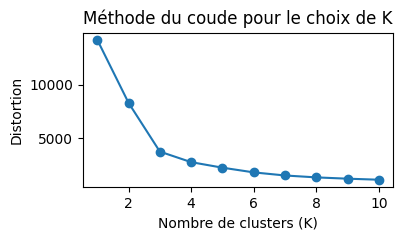

In [49]:
distortions = []
K = range(1, 11)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_s)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(4, 2))
plt.plot(K, distortions, marker='o')
plt.title('Méthode du coude pour le choix de K')
plt.xlabel('Nombre de clusters (K)')
plt.ylabel('Distortion')
plt.show()

On peut parfaitement constater que la "cassure" de la courbe a lieu lorque k=3. Donc, pour la suite, nous allons continuer avec un k=3 pour le model. 

3. Exécution du k-means

In [50]:
# Appliquer K-Means
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
model = kmeans.fit(X_s)
# Obtenir les étiquettes de cluster attribuées à chaque exemple
cluster_labels = model.labels_

/Users/user/Desktop/M2-DataScale/Machine_learning/project/M2DS-Drugs-Authorization-Classification/env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


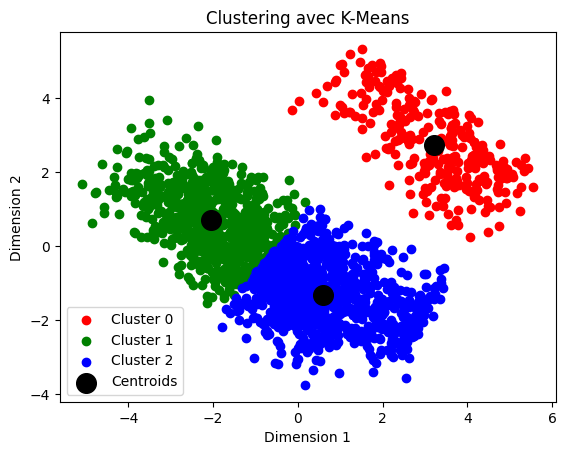

In [51]:
# Convertir cluster_labels en un tableau NumPy
cluster_labels = np.array(cluster_labels)

# Convertir les booléens en entiers (True -> 1, False -> 0)
cluster_labels = cluster_labels.astype(int)

# Modify the colors list to include only the number of colors equal to n_clusters
colors = ['r', 'g', 'b']

# Use the modified colors list in your loop
for i in range(n_clusters):
    plt.scatter(X_s[cluster_labels == i, 0], X_s[cluster_labels == i, 1], c=colors[i], label=f'Cluster {i}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', label='Centroids')
plt.legend()
plt.title('Clustering avec K-Means')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

4. Evaluation du clustering
C'est une partie importante pour évaluer la qualité du modèle K-Means et comprendre à quel point il a réussi à regrouper les données en clusters significatifs. Il existe plusieurs métriques pour l'évaluer. Parmi eux, l'indice de silhouette qui évalue à quel point les points d'un cluster sont similaires les uns aux autres par rapport aux points d'autres clusters. Il varie de -1 (mauvais regroupement) à +1 (regroupement bien défini). Une valeur proche de zéro indique un chevauchement entre les clusters.

In [52]:
silhouette = silhouette_score(X, kmeans.labels_)  # Score de silhouette
print("Score de silhouette:", silhouette)

Score de silhouette: 0.22173188527902413


Le Score de Silhouette d'environ 0,22 suggère que les clusters sont raisonnablement bien séparés et que les points de données sont plus proches du centre de leurs propres clusters que des clusters voisins les plus proches. En d'autres termes, il indique que les clusters sont assez bien définis, c'est d'ailleurs confirmé par la visualisation des clusters faite plus haut.

### Analyse supervisée

Dans cette partie, nous allons predire la variable cible `authorised_status` en utilisantles modèles de : `Régression logistique`,  `Random Forest` et `XGBoost`

#### 1. Protocole d'Études 

Nous allons dans un premier temps entrainer nos modèles avec les données déséquilibrées et voir les résultats des entrainements en se basant sur la `precision`, le `rappel` et la `f1-score`. 

Ensuite en se basant toujours sur ces metriques, nous allons ensuite entrainer le modele sur la variable cible reequilibree avec la technique d'oversampling.
Sachant que sur ces metriques, l'objectif est de le maximiser au mieux sur la classe `refused` 

- Visualisation de la distribution de la variable cible

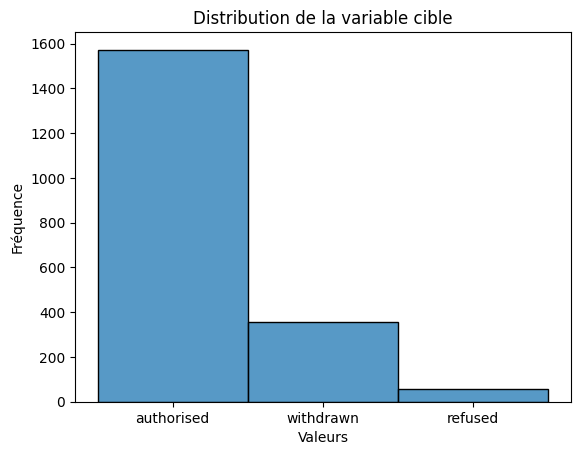

In [53]:
sns.histplot(y)
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.title('Distribution de la variable cible')
plt.show()

- Splitting des donnees en train et test 

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.3)

Ainsi nous avons un ensemble d'entrainement qui constitue 70% de notre ensemble de donnees et 30% constitue l'ensemble de test

#### 2. Entrainement avec les donnees "unbalanced" de la classe cible

Dans un premier temps, nous allons faire l'entrainement de nos modèles sur les données en conservant le déséquilibre de classes sur la variable cible et voir les résultats.

1. **Régression Logistique**

In [55]:
model_rl= LogisticRegression(C=0.1, penalty='l2', max_iter=1000, multi_class='ovr')
model_rl.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000, multi_class='ovr')

In [56]:
y_pred = model_rl.predict(X_test)
# Évaluez la performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("The accuracy is {}".format(accuracy))
print(report)

The accuracy is 0.949748743718593
              precision    recall  f1-score   support

  authorised       0.97      0.98      0.97       480
     refused       0.94      0.88      0.91        17
   withdrawn       0.87      0.83      0.85       100

    accuracy                           0.95       597
   macro avg       0.93      0.90      0.91       597
weighted avg       0.95      0.95      0.95       597



Nous voyons que notre modele a des metriques elevees sur la classe `authorised`en se basant sur les resultats de `f1-score`,`recall` et `precision`. Pour les classes `refused` et `withdrawn` malgre des ensembles petits de test(20 et 114) n'arrivent pas à depasser les 90% de `f1-score` 

- Optimisation des hyperparametres du modèle: nous allons faire l'optimisation des hyperparametres pour améliorer les performances du modèle.

In [57]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'max_iter': [100, 200, 300]
}
random_search = RandomizedSearchCV(model_rl, param_distributions=param_grid, n_iter=10, scoring='f1_micro', cv=5)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(C=0.1, max_iter=1000,
                                                multi_class='ovr'),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'max_iter': [100, 200, 300],
                                        'penalty': ['l2']},
                   scoring='f1_micro')

In [58]:
best_params = random_search.best_params_

In [59]:
best_model = LogisticRegression(**best_params)
best_model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=300)

In [60]:
y_pred = best_model.predict(X_test)
# Évaluez la performance
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

  authorised       0.97      0.97      0.97       480
     refused       1.00      0.94      0.97        17
   withdrawn       0.88      0.88      0.88       100

    accuracy                           0.96       597
   macro avg       0.95      0.93      0.94       597
weighted avg       0.96      0.96      0.96       597



Malgre, l'optimisation nous voyons clairement que la classe `withdrawn` se retrouve avec une `f1-scoe` nettement inférieure que les autres classes. Cependant, nous voyons que la prediction de la classe `refused` s'est amélioré. Nous allons utiliser la matrice de confusion pour mieux visualiser les resultats.
- Matrice de confusion

Matrice de Confusion :
 [[468   0  12]
 [  1  16   0]
 [ 12   0  88]]
['authorised' 'refused' 'withdrawn']


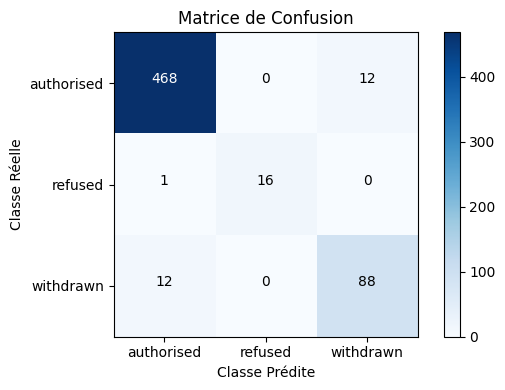

In [64]:
confusion = confusion_matrix(y_test, y_pred)
# Afficher la matrice de confusion (en tant que tableau)
print("Matrice de Confusion :\n", confusion)
# Visualisation de la répartition des classes prédites vs réelles
plt.figure(figsize=(6, 4))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.colorbar()
classes = np.unique(y.values)
tick_marks = np.arange(len(classes))
print(classes)
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.ylabel('Classe Réelle')
plt.xlabel('Classe Prédite')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(confusion[i, j]), horizontalalignment="center", color="white" if confusion[i, j] > confusion.max() / 2 else "black")

plt.tight_layout()
plt.show()

Avec cette matrice nous observons que 2 sur 19 des données de la categorie `refused` sont classées `authorised`. Ce qui est non negligeable. De meme pour la classe `withdrawn`

2. **RandomForestModel**

In [65]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [66]:
y_pred = model_rf.predict(X_test)
# Évaluez la performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("The accuracy is {}".format(accuracy))
print(report)

The accuracy is 0.9597989949748744
              precision    recall  f1-score   support

  authorised       0.97      0.99      0.98       480
     refused       1.00      1.00      1.00        17
   withdrawn       0.92      0.83      0.87       100

    accuracy                           0.96       597
   macro avg       0.96      0.94      0.95       597
weighted avg       0.96      0.96      0.96       597



Les résultats sont légèrement meilleurs que ceux obtenus avec la Regression Logistique. Le `rappel`, la `precision` et la `f1` score par classe sont meilleurs que ceux obtenus avec la Regression Logistique.

- Optimisation du modèle

In [67]:
param_dist = {
    'n_estimators': range(10,100,10),  # Nombre d'arbres
    'max_depth': [1, 10, 20, 30, 40,50]  # Profondeur maximale
}

In [68]:
random_search = RandomizedSearchCV(model_rf, param_distributions=param_dist, n_iter=10, scoring='f1_micro', cv=5)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [1, 10, 20, 30, 40, 50],
                                        'n_estimators': range(10, 100, 10)},
                   scoring='f1_micro')

In [39]:
best_params_rf = random_search.best_params_
best_model = RandomForestClassifier(**best_params_rf)
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, n_estimators=30)

In [69]:
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

  authorised       0.97      0.97      0.97       480
     refused       1.00      0.94      0.97        17
   withdrawn       0.88      0.88      0.88       100

    accuracy                           0.96       597
   macro avg       0.95      0.93      0.94       597
weighted avg       0.96      0.96      0.96       597



[0 1 2]
['authorised' 'refused' 'withdrawn']


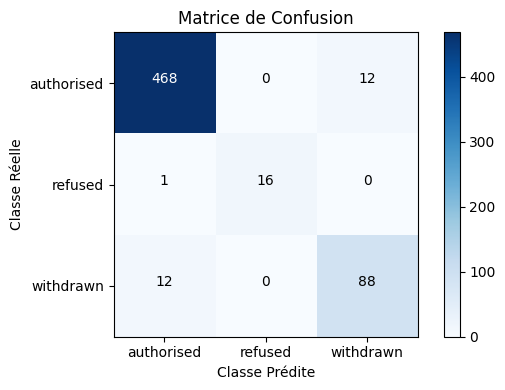

In [71]:
confusion = confusion_matrix(y_test, y_pred)

# Visualisation de la répartition des classes prédites vs réelles
plt.figure(figsize=(6, 4))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.colorbar()

classes = np.unique(y.values)
tick_marks = np.arange(len(classes))
print(tick_marks)
print(classes)
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.ylabel('Classe Réelle')
plt.xlabel('Classe Prédite')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(confusion[i, j]), horizontalalignment="center", color="white" if confusion[i, j] > confusion.max() / 2 else "black")

plt.tight_layout()
plt.show()

Pour la modalite `refused` nous voyons que l'ensemble des enregistrements ont été bien classés. Cependant pour la classe `withdrawn`, il y'a toujours une portion non negligeable classée dans la categorie `authorised`

3. **XGBoost**

Encodage de la variable cible

In [72]:
encoder = OneHotEncoder(sparse=False)
one_ytrain_encoded= encoder.fit_transform(y_train.values.reshape(-1,1))
one_ytest_encoded = encoder.fit_transform(y_test.values.reshape(-1,1))

/Users/user/Desktop/M2-DataScale/Machine_learning/project/M2DS-Drugs-Authorization-Classification/env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/user/Desktop/M2-DataScale/Machine_learning/project/M2DS-Drugs-Authorization-Classification/env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


- Entrainement

In [73]:
model_xgb = XGBClassifier(n_estimators=100, max_depth=20)
model_xgb.fit(X_train, one_ytrain_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [74]:
y_pred = model_xgb.predict(X_test)
report = classification_report(one_ytest_encoded, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       480
           1       1.00      1.00      1.00        17
           2       0.94      0.90      0.92       100

   micro avg       0.97      0.97      0.97       597
   macro avg       0.97      0.96      0.97       597
weighted avg       0.97      0.97      0.97       597
 samples avg       0.97      0.97      0.97       597



/Users/user/Desktop/M2-DataScale/Machine_learning/project/M2DS-Drugs-Authorization-Classification/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Par rapport au `f1-score`, on observe le meme que le modele RandomForest sur les classes minoritaires.

- Optimisation du modèle

In [75]:
param_space = {
    'n_estimators': Integer(100, 1000),  # Nombre d'arbres
    'max_depth': Integer(3, 10),  # Profondeur maximale
    'learning_rate': Real(0.01, 0.3),  # Taux d'apprentissage
    'subsample': Real(0.5, 1.0),  # Fraction d'échantillons utilisés pour l'apprentissage de chaque arbre
    'colsample_bytree': Real(0.5, 1.0),  # Fraction de colonnes utilisées pour l'apprentissage de chaque arbre
    'gamma': Real(0, 1.0)  # Paramètre de régularisation
}

In [76]:
bayes_search = BayesSearchCV(model_xgb, param_space, n_iter=50, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

### Entrainement sur les donnees rééquilibrées 

Dans cette partie nous allons continuer l'apprentissage supervise mais en appliquant une technique de reequilibrage sur les classes de notre variable cible

In [78]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

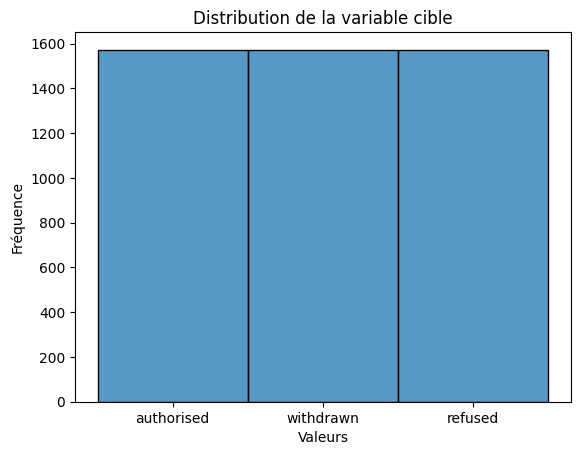

In [79]:
sns.histplot(y_resampled)
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.title('Distribution de la variable cible')
plt.show()

Avec cette technique, nous voyons maintenant que les classes de notre variable cible sont equi-distribuees

- Split des donneees

In [80]:
X_train_resamp, X_test_resamp, y_train_resamp, y_test_resamp = train_test_split(X_resampled, y_resampled, test_size=0.3)

#### Entrainement

- Regression Logistique

In [81]:
model_rl_rs = LogisticRegression(C=0.1, penalty='l2', max_iter=1000, multi_class='ovr')

In [82]:
model_rl_rs.fit(X_train_resamp, y_train_resamp)

/Users/user/Desktop/M2-DataScale/Machine_learning/project/M2DS-Drugs-Authorization-Classification/env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1, max_iter=1000, multi_class='ovr')

In [83]:
y_predict_resamp = model_rl_rs.predict(X_test_resamp)

In [84]:
report = classification_report(y_test_resamp, y_predict_resamp)
print(report)

              precision    recall  f1-score   support

  authorised       0.91      0.94      0.93       463
     refused       1.00      1.00      1.00       465
   withdrawn       0.94      0.91      0.93       488

    accuracy                           0.95      1416
   macro avg       0.95      0.95      0.95      1416
weighted avg       0.95      0.95      0.95      1416



Sans `optimisation`, on obtient de meilleurs `precision`, `rappel` et `f1-score` par rapport a la Regression LOgistique sur les donnees desequilibrees 

- Optimisation du modele 

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'max_iter': range(300,1000)
}

#grid_search = GridSearchCV(model_rl, param_grid, scoring='f1_micro', cv=5)
#grid_search.fit(X_train, y_train)

random_search = RandomizedSearchCV(model_rl_rs, param_distributions=param_grid, n_iter=10, scoring='f1_micro', cv=5)
random_search.fit(X_train_resamp, y_train_resamp)

In [ ]:
best_params = random_search.best_params_
best_model = LogisticRegression(**best_params)
best_model.fit(X_train_resamp, y_train_resamp)

In [87]:
y_pred = best_model.predict(X_test_resamp)
report = classification_report(y_test_resamp, y_pred)
print(report)

              precision    recall  f1-score   support

  authorised       0.91      0.95      0.93       463
     refused       0.99      1.00      1.00       465
   withdrawn       0.96      0.91      0.93       488

    accuracy                           0.95      1416
   macro avg       0.95      0.95      0.95      1416
weighted avg       0.95      0.95      0.95      1416



Les résultats obtenus apres optimisation sont les mêmes sur le`f1-score` qu'avant optimisation. Sur le `rappel` et la `precision` les résultats sont nettement meilleurs qu'avant l'optimisation

Matrice de Confusion :
 [[441   3  19]
 [  0 465   0]
 [ 43   1 444]]
[0 1 2]
['authorised' 'refused' 'withdrawn']


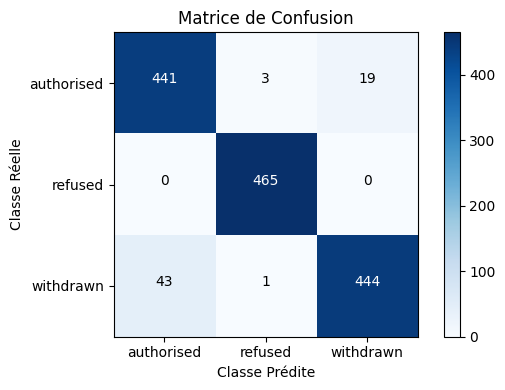

In [88]:
confusion = confusion_matrix(y_test_resamp, y_pred)

# Afficher la matrice de confusion (en tant que tableau)
print("Matrice de Confusion :\n", confusion)

# Visualisation de la répartition des classes prédites vs réelles
plt.figure(figsize=(6, 4))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.colorbar()


classes = np.unique(y.values)
tick_marks = np.arange(len(classes))
print(tick_marks)
print(classes)
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.ylabel('Classe Réelle')
plt.xlabel('Classe Prédite')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(confusion[i, j]), horizontalalignment="center", color="white" if confusion[i, j] > confusion.max() / 2 else "black")

plt.tight_layout()
plt.show()

- RandomForestClassifier

In [89]:
model_rf_rs = RandomForestClassifier()

In [90]:
model_rf_rs.fit(X_train_resamp, y_train_resamp)

RandomForestClassifier()

In [91]:
y_pred =  model_rf_rs.predict(X_test_resamp)

report = classification_report(y_test_resamp, y_pred)
print(report)

              precision    recall  f1-score   support

  authorised       0.94      0.98      0.96       463
     refused       1.00      1.00      1.00       465
   withdrawn       0.98      0.94      0.96       488

    accuracy                           0.97      1416
   macro avg       0.97      0.97      0.97      1416
weighted avg       0.97      0.97      0.97      1416



Avec la `f1-score`, on obtient des resultats meilleurs que l'ensemble des models precedents sans meme de faire l'optimisation

- Optimisation du randomForest

In [92]:
param_dist = {
    'n_estimators': range(10,100,10),  # Nombre d'arbres
    'max_depth': [1, 10, 20, 30, 40,50]  # Profondeur maximale
}

In [93]:
random_search = RandomizedSearchCV(model_rf_rs, param_distributions=param_dist, n_iter=10, scoring='f1_micro', cv=5)
random_search.fit(X_train_resamp, y_train_resamp)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [1, 10, 20, 30, 40, 50],
                                        'n_estimators': range(10, 100, 10)},
                   scoring='f1_micro')

In [94]:
best_params =  random_search.best_params_
best_model = RandomForestClassifier(**best_params)

In [95]:
best_model.fit(X_train_resamp, y_train_resamp)

RandomForestClassifier(max_depth=50, n_estimators=70)

In [96]:
y_pred = best_model.predict(X_test_resamp)
report = classification_report(y_test_resamp, y_pred)

print(report)

              precision    recall  f1-score   support

  authorised       0.95      0.98      0.96       463
     refused       1.00      1.00      1.00       465
   withdrawn       0.98      0.95      0.96       488

    accuracy                           0.98      1416
   macro avg       0.98      0.98      0.98      1416
weighted avg       0.98      0.98      0.98      1416



Les resultats de cet entrainement sont quasi-identiques qu'avant l'optimisation

Matrice de Confusion :
 [[454   0   9]
 [  0 465   0]
 [ 24   1 463]]
[0 1 2]
['authorised' 'refused' 'withdrawn']


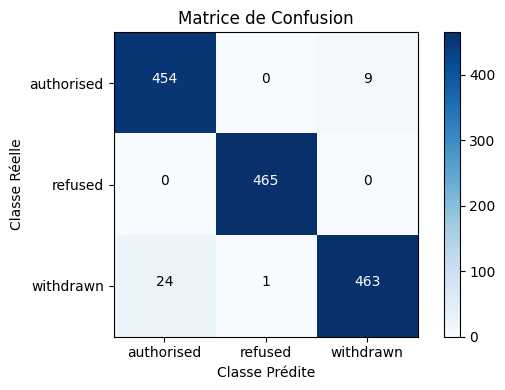

In [97]:
confusion = confusion_matrix(y_test_resamp, y_pred)

# Afficher la matrice de confusion (en tant que tableau)
print("Matrice de Confusion :\n", confusion)

# Visualisation de la répartition des classes prédites vs réelles
plt.figure(figsize=(6, 4))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.colorbar()


classes = np.unique(y.values)
tick_marks = np.arange(len(classes))
print(tick_marks)
print(classes)
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.ylabel('Classe Réelle')
plt.xlabel('Classe Prédite')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(confusion[i, j]), horizontalalignment="center", color="white" if confusion[i, j] > confusion.max() / 2 else "black")

plt.tight_layout()
plt.show()

La matrice de confusion obtenu vient confirmer les performances de ce modele par rapport aux precedents. L'ensembles des enregistrements de la categorie `refused` sont bien classees et la proportion de classification  incorrecte de la classe `withdrawn` est faible 

- XGBoost

Encodage de la variable cible

In [98]:
encoder = OneHotEncoder(sparse=False)

In [99]:
one_ytrain_rs_encoded= encoder.fit_transform(y_train_resamp.values.reshape(-1,1))

/Users/user/Desktop/M2-DataScale/Machine_learning/project/M2DS-Drugs-Authorization-Classification/env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [100]:
one_ytest_rs_encoded= encoder.fit_transform(y_test_resamp.values.reshape(-1,1))

/Users/user/Desktop/M2-DataScale/Machine_learning/project/M2DS-Drugs-Authorization-Classification/env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [101]:
model_xgb_rs = XGBClassifier(n_estimators=100, max_depth=20)

In [102]:
model_xgb_rs.fit(X_train_resamp, one_ytrain_rs_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [103]:
y_pred = model_xgb_rs.predict(X_test_resamp)

In [104]:
report = classification_report(one_ytest_rs_encoded, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       463
           1       1.00      1.00      1.00       465
           2       0.98      0.96      0.97       488

   micro avg       0.98      0.98      0.98      1416
   macro avg       0.98      0.98      0.98      1416
weighted avg       0.98      0.98      0.98      1416
 samples avg       0.98      0.98      0.98      1416



/Users/user/Desktop/M2-DataScale/Machine_learning/project/M2DS-Drugs-Authorization-Classification/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Avec ce modèle, les metriques sont meilleures tant sur la `f1-score` que sur la `precision` et le `recall` 

### Conclusion
A la fin des entrainements de nos differents modeles, le modele choisi est le `XGBClassifier` sur la technique d'oversampling qui presente les meilleures metriques sur l'ensemble des modèles 

<div style="text-align:center; weignt:bold"><h1>FIN</h1></div>